In [1]:
# Imports
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re

from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


'''
http://scikit-learn.org/stable/modules/ensemble.html#voting-classifier

Check this out as a possible solution if recommended can be fairly well predicted by multiple models
'''

C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


'\nhttp://scikit-learn.org/stable/modules/ensemble.html#voting-classifier\n\nCheck this out as a possible solution if recommended can be fairly well predicted by multiple models\n'

In [2]:
# Set up file read/folder structure
os.chdir("C:\\Users\\erroden\\Desktop\\Capstone\\")

# Local Sources
# Initial focus will be on the airline data set but others may be stitched on to enrich the data
airline = pd.read_csv("data\\airline_2.csv")

airport = pd.read_csv("data\\airport.csv")
lounge = pd.read_csv("data\\lounge.csv")
seat = pd.read_csv("data\\seat.csv")

C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Add on text length as an extra data point - https://medium.com/tensorist/classifying-yelp-reviews-using-nltk-and-scikit-learn-c58e71e962d9
airline["text_len"] = airline.content.apply(len)

In [4]:
airline.drop(airline.columns[0], axis=1, inplace=True) # drop index column

In [5]:
airline.columns

Index(['aircraft', 'cabin_flown', 'cabin_staff_rating', 'date',
       'food_beverages_rating', 'ground_service_rating',
       'inflight_entertainment_rating', 'recommended', 'route',
       'seat_comfort_rating', 'type_traveller', 'value_money_rating',
       'wifi_connectivity_rating', 'airline_name', 'author', 'author_country',
       'content', 'date_published', 'link', 'overall_rating', 'title',
       'text_len'],
      dtype='object')

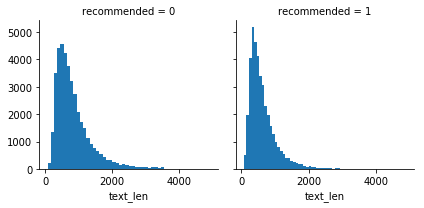

In [6]:
# visualize how words compare with recommended

g = sns.FacetGrid(data=airline, col='recommended')
g.map(plt.hist, 'text_len', bins=50)

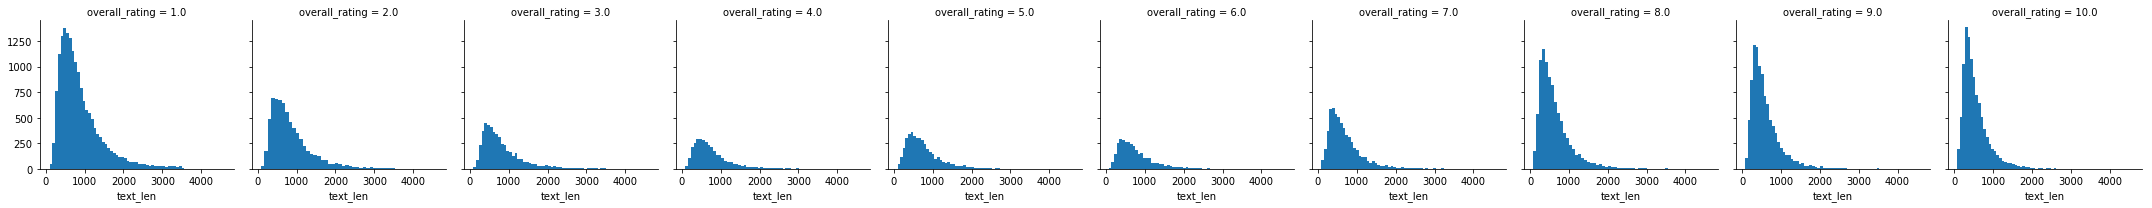

In [7]:
# visualize how words compare with recommended overall_rating

g = sns.FacetGrid(data=airline, col='overall_rating')
g.map(plt.hist, 'text_len', bins=50)

In [8]:
# generate tokens
airline['tokens'] = airline.content.apply(lambda x: x.split(" "))

airline['tokens'].head()

0    [We, were, traveling, from, Paris, to, Skopje,...
1    [Ljubljana, to, Munich., Adria's, checkin, sys...
2    [A, very, unpleasant, experience, for, my, fam...
3    [Frankfurt, to, Ljubljana., Flight, was, very,...
4    [Ljubljana, to, Frankfurt., Flight, delayed, f...
Name: tokens, dtype: object

Looks like it's off to a good start. 

In [9]:
stops = set(stopwords.words('english'))

In [10]:
airline['clean'] = airline['tokens'].apply(lambda x: [word for word in x if word not in stops])

In [11]:
airline['clean'] = airline['clean'].apply(lambda x: [word for word in x if re.search('^[a-zA-Z]+', word)])

In [12]:
# Lemmatizer 
lemmatizer = nltk.WordNetLemmatizer()

airline['clean'] = airline['clean'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [13]:
airline['ready'] =  airline['clean'].apply(lambda x: ' '.join(x))

In [14]:
# Vectorize and fit the model

from sklearn.feature_extraction.text import TfidfVectorizer

# parameters set to try to reduce features space to something that won't crash my computer
tfidf = TfidfVectorizer(max_df = .9, min_df=.05)

# running on portion of population to try to get results to work
X = tfidf.fit_transform(airline['ready'])

In [15]:
X.shape # records x tokens

(79802, 235)

In [16]:
# Classification using tfidf and recommendation as output variable

y = airline.recommended

In [17]:
# save the model for quick loading in the future
from sklearn.externals import joblib
joblib.dump(tfidf, 'tfidf.pkl') 


# load the model
from sklearn.externals import joblib
tfidf2 = joblib.load('tfidf.pkl') 

In [18]:
# logistic regression

logreg = LogisticRegression()
cross_val_score(logreg, X, y, cv=5, scoring='roc_auc').mean()

0.9286898953759015

In [20]:
logreg = LogisticRegression()
cross_val_score(logreg, X, y, cv=5, scoring='accuracy').mean()

0.8576602531640798

Text(0,0.5,'True Positive Rate (Sensitivity)')

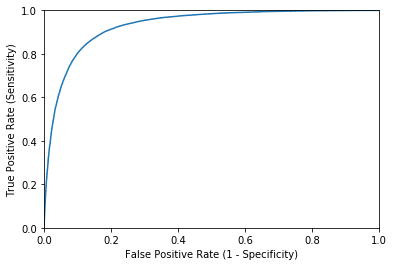

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

logreg.fit(X_train, y_train)


fpr, tpr, thresholds = metrics.roc_curve(y, logreg.predict_proba(X)[:, 1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

0.9187830719352581

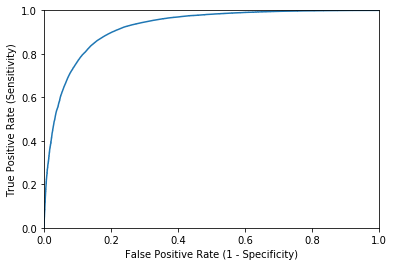

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


GB = GradientBoostingClassifier()
GB.fit(X_train, y_train)

fpr, tpr, thresholds = metrics.roc_curve(y, GB.predict_proba(X)[:, 1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

print(cross_val_score(GB, X, y, cv=3, scoring='roc_auc').mean())
print(cross_val_score(GB, X, y, cv=3, scoring='accuracy').mean())

In [22]:
cross_val_score(GB, X, y, cv=3, scoring='accuracy').mean() # come back to this and add GB and accuracy for slightly improved versin below

0.8432997270816981

In [23]:
# Now add in sentiment

from textblob import TextBlob, Word

airline['tokens'] = airline.content.apply(lambda x: x.split(" "))

# create a text blob column 
airline['blob'] = airline.content.apply(lambda x: TextBlob(x))

In [24]:
airline.blob.head()

0    (W, e,  , w, e, r, e,  , t, r, a, v, e, l, i, ...
1    (L, j, u, b, l, j, a, n, a,  , t, o,  , M, u, ...
2    (A,  , v, e, r, y,  , u, n, p, l, e, a, s, a, ...
3    (F, r, a, n, k, f, u, r, t,  , t, o,  , L, j, ...
4    (L, j, u, b, l, j, a, n, a,  , t, o,  , F, r, ...
Name: blob, dtype: object

In [25]:
# get polarity scores

airline['polarity'] = [sent.sentiment.polarity for sent in airline.blob]

In [26]:
airline.head()[['polarity', 'content']]

,polarity,content
0,-0.001667,We were traveling from Paris to Skopje on May ...
1,-0.007500,Ljubljana to Munich. Adria's checkin system is...
2,0.037111,A very unpleasant experience for my family. We...
3,0.206667,Frankfurt to Ljubljana. Flight was very comfor...
4,0.181345,Ljubljana to Frankfurt. Flight delayed for mor...


In [27]:
airline.content[3] # check to see if content matches sentient

'Frankfurt to Ljubljana. Flight was very comfortable, professional crew. The monitors above passengers provide informations about flight (speed, altitude, temperature, time to landing, etc.)'

In [28]:
# logistic regression using sentiment/polarity only

X = airline.polarity
X = X.values.reshape(-1,1)
y = airline.recommended

logreg = LogisticRegression()
cross_val_score(logreg, X, y, cv=5, scoring='roc_auc').mean()

0.8851731594453266

This performed slightly worse than using just the tfidf

Text(0,0.5,'True Positive Rate (Sensitivity)')

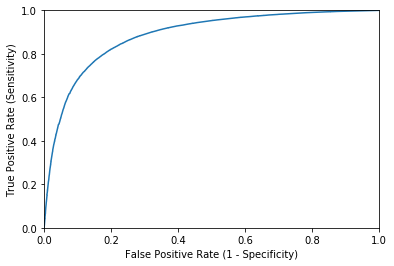

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

logreg.fit(X_train, y_train)


fpr, tpr, thresholds = metrics.roc_curve(y, logreg.predict_proba(X)[:, 1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

**Sentiment alone performs more poorly than using a tfidf, but not terrible performance

*What if we use both?

In [30]:
# parameters set to try to reduce features space to something that won't crash my computer
tfidf = TfidfVectorizer(max_df = .9, min_df=.05)

# running on portion of population to try to get results to work
X = tfidf.fit_transform(airline['ready'])

X = pd.DataFrame(X.toarray())

In [31]:
X['polarity'] = airline.polarity
X['text_len'] = airline['ready'].apply(len)

In [39]:
# without normalization
logreg = LogisticRegression()
print(cross_val_score(logreg, X, y, cv=5, scoring='roc_auc').mean())
print(cross_val_score(logreg, X, y, cv=5, scoring='accuracy').mean())

0.9411041947235503
0.8745520425020951


In [33]:
logreg = logreg.fit(X,y)

In [34]:
# save the models for quick loading in the future
from sklearn.externals import joblib
joblib.dump(logreg, 'logreg_tfidf_and_sent.pkl') 

# load the model
from sklearn.externals import joblib
logreg = joblib.load('logreg_tfidf_and_sent.pkl')

In [35]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,227,228,229,230,231,232,233,234,polarity,text_len
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.158933,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.094825,0.000000,0.0,-0.001667,663
1,0.187015,0.0,0.133866,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.169378,0.0,0.0,0.107459,0.166778,0.0,-0.007500,743
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.326775,0.493480,0.0,...,0.0,0.089177,0.092816,0.0,0.0,0.000000,0.000000,0.0,0.037111,1169
3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.206667,151
4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.267766,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.181345,319


Text(0,0.5,'True Positive Rate (Sensitivity)')

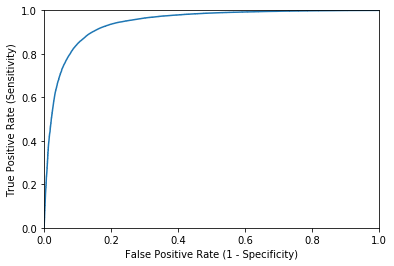

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

logreg.fit(X_train, y_train)


fpr, tpr, thresholds = metrics.roc_curve(y, logreg.predict_proba(X)[:, 1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

0.9335243018454386
0.8619333572267575


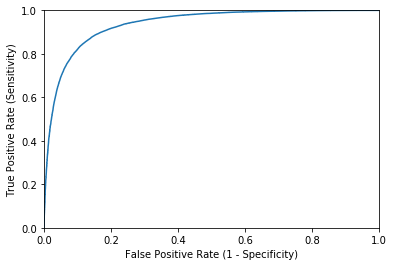

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


GB = GradientBoostingClassifier()
GB.fit(X_train, y_train)

fpr, tpr, thresholds = metrics.roc_curve(y, GB.predict_proba(X)[:, 1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

print(cross_val_score(GB, X, y, cv=3, scoring='roc_auc').mean())
print(cross_val_score(GB, X, y, cv=3, scoring='accuracy').mean())

In [35]:
airline_no_text = airline.drop(['tokens', 'clean', 'ready', 'blob'], axis=1)

In [36]:
X = tfidf.fit_transform(airline['ready'])
X = pd.DataFrame(X.toarray())
airline_printout = pd.concat([airline_no_text,X],axis=1)

In [37]:
# save df with tfidf for later use. Column names 0-234 are the tfidf columns

# Set up file read/folder structure
import os
os.chdir("C:\\Users\\erroden\\Desktop\\Capstone\\")

airline_printout.to_csv('data\\airline_with_tfidf.csv', index=False)

In [38]:
airline2 = pd.read_csv('data\\airline_with_tfidf.csv')

C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [39]:
tfidf_col_length = X.shape[1]

In [40]:
airline2.head()

,aircraft,cabin_flown,cabin_staff_rating,date,food_beverages_rating,ground_service_rating,inflight_entertainment_rating,recommended,route,seat_comfort_rating,...,225,226,227,228,229,230,231,232,233,234
0,NaN,Economy Class,3.0,May 2018,NaN,3.0,NaN,0,Paris to Skopje via Ljubljana,3.0,...,0.108964,0.0,0.0,0.000000,0.000000,0.0,0.0,0.094825,0.000000,0.0
1,NaN,Economy Class,2.0,June 2018,2.0,2.0,NaN,0,Ljubljana to Munich,1.0,...,0.000000,0.0,0.0,0.000000,0.169378,0.0,0.0,0.107459,0.166778,0.0
2,A319,Economy Class,3.0,June 2018,NaN,1.0,NaN,0,Ljubljana to Prague,3.0,...,0.067665,0.0,0.0,0.089177,0.092816,0.0,0.0,0.000000,0.000000,0.0
3,NaN,Economy Class,5.0,April 2018,5.0,5.0,NaN,1,Frankfurt to Ljubljana,5.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
4,NaN,Economy Class,1.0,March 2018,1.0,1.0,1.0,0,Ljubljana to Frankfurt,2.0,...,0.183579,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0


In [41]:
''' 
The next step is to try to fill in NA values where possible for additional columns
'''

' \nThe next step is to try to fill in NA values where possible for additional columns\n'

Low-Medium Null Values - cabin_flown, cabin_staff_rating,overall rating, value_money_rating, seat_comfort_rating, food_beverages_rating
Medium-high null values - type_traveller, inflight_entertainment_rating, ground_service_rating
More null than not null - wifi_connectivity_rating - **Dropped**

In [42]:
# use available data to determine the best simple classification approach to use to predict y and return the model, its accuracy
# and the column being predicted. At that point the model can either be used to predict the missing values or ignored depending on the accuracy

# y_name should be the string column name of the y. Data should contain only the input columns and y. text field should have column 'ready'
def get_na_model(y_name, data):
    
    # get dataframe of where y is not null
    data = data[data[y_name] == data[y_name]]
    
    # create tfidf
    tfidf = TfidfVectorizer(max_df = .9, min_df=.05)
    
    # get column names and drop text column
    cols = list(data.columns)
    cols.remove('ready')
    
    # fit tfidf and add back other data
    X = tfidf.fit_transform(data['ready'])
    X = pd.DataFrame(X.toarray())
    
    # concat?
    X.reset_index(drop=True, inplace=True)
    subset = data[cols].reset_index(drop=True)

    X = pd.concat([X, subset], axis=1)
    
    scaler = MinMaxScaler()
    
    y = X[y_name]
    X.drop(y_name, axis=1,inplace=True)
    
    X = scaler.fit_transform(X)
    
    # initiate models
    # model = KNeighborsClassifier(n_jobs=-1) # crashes on running
    models = {
        'NB': MultinomialNB(), 
        'decision tree': tree.DecisionTreeClassifier(),
        'random forest': RandomForestClassifier(n_jobs=-1), 
        'log reg': LogisticRegression(),
        'linear SVC': LinearSVC(), 
        'Passive Aggressive Classifier': PassiveAggressiveClassifier(),
        'Ada Boost': AdaBoostClassifier(),
        'Gradient Boosting': GradientBoostingClassifier()
    }
    
    # add variables to track best model
    max_acc = -.01
    best_model = None

    '''
    Determine how to pass gridsearch through
    '''
    # loop through each model and track accuracy
    for m in models:
        print('processing {}'.format(m))
        model = models[m]
        acc = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
        print("{} model scored {} accuracy".format(m, acc))
        if acc > max_acc:
            best_model = models[m]
            max_acc = acc
            
    return y_name, max_acc, best_model

In [43]:
'''
This process takes quite a long time so if you only want the results scroll down and you can read them in
'''

y_list = ['cabin_staff_rating', 'food_beverages_rating', 'ground_service_rating', 'inflight_entertainment_rating', 'type_traveller', 'wifi_connectivity_rating', 'cabin_flown']
results = []

for y in y_list:
    print('column: {}'.format(y))
    
    get_model_data = airline[['ready', 'polarity', 'text_len', 'overall_rating', y]]
    get_model_data = get_model_data[get_model_data['overall_rating'].notna()] # Dropping where there are null values. 

    result = get_na_model(y, get_model_data)
    results.append(result)

column: cabin_staff_rating
processing NB
NB model scored 0.4929929387270085 accuracy
processing random forest
random forest model scored 0.5172505793659832 accuracy
processing Ada Boost
Ada Boost model scored 0.5416701024178228 accuracy
processing log reg
log reg model scored 0.5493449049320824 accuracy
processing Gradient Boosting
Gradient Boosting model scored 0.5689949188465712 accuracy
processing linear SVC
linear SVC model scored 0.540378467073258 accuracy
processing Passive Aggressive Classifier


C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1

Passive Aggressive Classifier model scored 0.4239038540786348 accuracy
processing decision tree
decision tree model scored 0.45813945302624004 accuracy
column: food_beverages_rating
processing NB
NB model scored 0.4359012749545738 accuracy
processing random forest
random forest model scored 0.4406296064769653 accuracy
processing Ada Boost
Ada Boost model scored 0.4874863594098901 accuracy
processing log reg
log reg model scored 0.49063351424093116 accuracy
processing Gradient Boosting
Gradient Boosting model scored 0.5022819705425657 accuracy
processing linear SVC
linear SVC model scored 0.48204933142161843 accuracy
processing Passive Aggressive Classifier


C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1

Passive Aggressive Classifier model scored 0.3610649699867936 accuracy
processing decision tree
decision tree model scored 0.38653895650220654 accuracy
column: ground_service_rating
processing NB
NB model scored 0.5633203685601255 accuracy
processing random forest
random forest model scored 0.5685769163352664 accuracy
processing Ada Boost
Ada Boost model scored 0.6137229998453257 accuracy
processing log reg
log reg model scored 0.6038965689931226 accuracy
processing Gradient Boosting
Gradient Boosting model scored 0.617511712225929 accuracy
processing linear SVC
linear SVC model scored 0.5967593886241669 accuracy
processing Passive Aggressive Classifier


C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1

Passive Aggressive Classifier model scored 0.5023449500886026 accuracy
processing decision tree
decision tree model scored 0.5177593452574889 accuracy
column: inflight_entertainment_rating
processing NB
NB model scored 0.40300525685868915 accuracy
processing random forest
random forest model scored 0.38988775500833717 accuracy
processing Ada Boost
Ada Boost model scored 0.4412670647162843 accuracy
processing log reg
log reg model scored 0.4446868193658082 accuracy
processing Gradient Boosting
Gradient Boosting model scored 0.45063318752403675 accuracy
processing linear SVC
linear SVC model scored 0.44006169981781335 accuracy
processing Passive Aggressive Classifier


C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1

Passive Aggressive Classifier model scored 0.31973123587295377 accuracy
processing decision tree
decision tree model scored 0.32939552163017094 accuracy
column: type_traveller
processing NB
NB model scored 0.40728939911874906 accuracy
processing random forest
random forest model scored 0.37242213774214716 accuracy
processing Ada Boost
Ada Boost model scored 0.445851308184577 accuracy
processing log reg
log reg model scored 0.44728628671410825 accuracy
processing Gradient Boosting
Gradient Boosting model scored 0.4532917745911864 accuracy
processing linear SVC
linear SVC model scored 0.4479184553141688 accuracy
processing Passive Aggressive Classifier


C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1

Passive Aggressive Classifier model scored 0.3396700172704752 accuracy
processing decision tree
decision tree model scored 0.3305046292384395 accuracy
column: wifi_connectivity_rating
processing NB


C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


NB model scored 0.5764961516946115 accuracy
processing random forest


C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


random forest model scored 0.5872641844773765 accuracy
processing Ada Boost


C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


Ada Boost model scored 0.5243057012702974 accuracy
processing log reg


C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


log reg model scored 0.6033168756461416 accuracy
processing Gradient Boosting


C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


Gradient Boosting model scored 0.6085156880021774 accuracy
processing linear SVC


C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


linear SVC model scored 0.6003479380795527 accuracy
processing Passive Aggressive Classifier


C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and to

Passive Aggressive Classifier model scored 0.4988074956860059 accuracy
processing decision tree


C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


decision tree model scored 0.5048624291263841 accuracy
column: cabin_flown
processing NB
NB model scored 0.8359770077241491 accuracy
processing random forest
random forest model scored 0.8630436492004401 accuracy
processing Ada Boost
Ada Boost model scored 0.8674387002548732 accuracy
processing log reg
log reg model scored 0.8736899109797951 accuracy
processing Gradient Boosting
Gradient Boosting model scored 0.875382549950196 accuracy
processing linear SVC
linear SVC model scored 0.8711102651801863 accuracy
processing Passive Aggressive Classifier


C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1

Passive Aggressive Classifier model scored 0.7750382739287895 accuracy
processing decision tree
decision tree model scored 0.7997247863597712 accuracy


In [44]:
results

[('cabin_staff_rating',
  0.5689949188465712,
  GradientBoostingClassifier(criterion='friedman_mse', init=None,
                learning_rate=0.1, loss='deviance', max_depth=3,
                max_features=None, max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=100,
                presort='auto', random_state=None, subsample=1.0, verbose=0,
                warm_start=False)),
 ('food_beverages_rating',
  0.5022819705425657,
  GradientBoostingClassifier(criterion='friedman_mse', init=None,
                learning_rate=0.1, loss='deviance', max_depth=3,
                max_features=None, max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=100,
                presort='auto', random_s

In [45]:
# get columns ready for fitting model to predict
model_columns = ['polarity', 'text_len', 'overall_rating']
tfidf_cols = list(range(tfidf_col_length)) # add columns for tfidf (this would be generated dynamically)
model_columns.extend([str(x) for x in tfidf_cols]) 

In [46]:
# use prediction models where applicable to enrich data
y_names = ['cabin_flown', 'wifi_connectivity_rating', 'ground_service_rating']
airline3 = airline2[airline2['overall_rating'].notna()] # Dropping where there are null values to be consistent with predicions

for r in results:
    if r[0] in y_names:
        
        # get data for specific column
        model = r[2]
        y_name = r[0]
        
        # set up data sets
        train = airline3[airline3[y_name].notna()]
        test = airline3[airline3[y_name].isna()]
        
        # fit and predict
        model.fit(train[model_columns], train[y_name])
        test[y_name] = model.predict(test[model_columns])
        
        # join train and test
        airline3 = pd.concat([train, test])
        
airline3.info()

C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<class 'pandas.core.frame.DataFrame'>
Int64Index: 75336 entries, 4 to 79791
Columns: 258 entries, aircraft to 234
dtypes: float64(245), int64(2), object(11)
memory usage: 148.9+ MB


In [47]:
airline3[y_names].info() # now those values are filled

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75336 entries, 4 to 79791
Data columns (total 3 columns):
cabin_flown                 75336 non-null object
wifi_connectivity_rating    75336 non-null float64
ground_service_rating       75336 non-null float64
dtypes: float64(2), object(1)
memory usage: 2.3+ MB


In [48]:
airline3.to_csv('data\\imputed_airlines.csv', index=False)

In [49]:
airline3.columns[:23] # columns excluding tfidf columns

Index(['aircraft', 'cabin_flown', 'cabin_staff_rating', 'date',
       'food_beverages_rating', 'ground_service_rating',
       'inflight_entertainment_rating', 'recommended', 'route',
       'seat_comfort_rating', 'type_traveller', 'value_money_rating',
       'wifi_connectivity_rating', 'airline_name', 'author', 'author_country',
       'content', 'date_published', 'link', 'overall_rating', 'title',
       'text_len', 'polarity'],
      dtype='object')

In [50]:
# add dummies for categorical and drop unused columns
airline3_dummys = pd.get_dummies(airline3, columns=['cabin_flown', 'type_traveller'])

In [51]:
airline3_dummys.columns

Index(['aircraft', 'cabin_staff_rating', 'date', 'food_beverages_rating',
       'ground_service_rating', 'inflight_entertainment_rating', 'recommended',
       'route', 'seat_comfort_rating', 'value_money_rating',
       ...
       '233', '234', 'cabin_flown_Business Class', 'cabin_flown_Economy Class',
       'cabin_flown_First Class', 'cabin_flown_Premium Economy',
       'type_traveller_Business', 'type_traveller_Couple Leisure',
       'type_traveller_Family Leisure', 'type_traveller_Solo Leisure'],
      dtype='object', length=264)

In [52]:
# drop columns that won't be used in modeling (either not useful data or too sparse)
airline3_dummys.drop(['aircraft', 'date', 'inflight_entertainment_rating', 
                      'ground_service_rating', 'wifi_connectivity_rating', 'route', 'airline_name', 
                      'author', 'author_country', 'content', 'date_published', 'link', 'title'], axis=1, inplace=True, errors='ignore')


In [53]:
airline3_dummys.columns

Index(['cabin_staff_rating', 'food_beverages_rating', 'recommended',
       'seat_comfort_rating', 'value_money_rating', 'overall_rating',
       'text_len', 'polarity', '0', '1',
       ...
       '233', '234', 'cabin_flown_Business Class', 'cabin_flown_Economy Class',
       'cabin_flown_First Class', 'cabin_flown_Premium Economy',
       'type_traveller_Business', 'type_traveller_Couple Leisure',
       'type_traveller_Family Leisure', 'type_traveller_Solo Leisure'],
      dtype='object', length=251)

In [54]:
# save intermediate step
airline3_dummys.to_csv('data\\imputed_airlines_with_dummys.csv', index=False)

In [41]:
# read in data - can start here to save the processing time
airline_model_ready = pd.read_csv('data\\imputed_airlines_with_dummys.csv')

In [42]:
airline_model_ready.shape

(75336, 251)

In [43]:
airline_model_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75336 entries, 0 to 75335
Columns: 251 entries, cabin_staff_rating to type_traveller_Solo Leisure
dtypes: float64(241), int64(10)
memory usage: 144.3 MB


In [44]:
# removes ~15k records
airline_model_ready.dropna(inplace=True)
airline_model_ready.shape

(60692, 251)

In [45]:
# Add additional columns to be included in the model

X = airline_model_ready.drop(['recommended'], axis=1)

y = airline_model_ready.recommended

logreg = LogisticRegression()
cross_val_score(logreg, X, y, cv=3, scoring='roc_auc').mean()

0.9907758881585699

In [48]:
cross_val_score(logreg, X, y, cv=3, scoring='accuracy').mean()

0.9488067385212405

In [47]:
X.columns

Index(['cabin_staff_rating', 'food_beverages_rating', 'seat_comfort_rating',
       'value_money_rating', 'overall_rating', 'text_len', 'polarity', '0',
       '1', '2',
       ...
       '233', '234', 'cabin_flown_Business Class', 'cabin_flown_Economy Class',
       'cabin_flown_First Class', 'cabin_flown_Premium Economy',
       'type_traveller_Business', 'type_traveller_Couple Leisure',
       'type_traveller_Family Leisure', 'type_traveller_Solo Leisure'],
      dtype='object', length=250)

Text(0,0.5,'True Positive Rate (Sensitivity)')

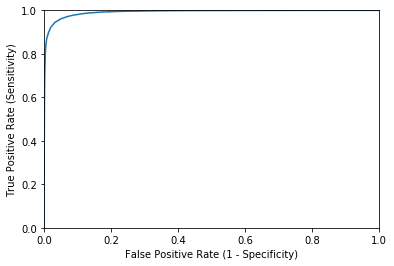

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

logreg.fit(X_train, y_train)

fpr, tpr, thresholds = metrics.roc_curve(y, logreg.predict_proba(X)[:, 1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

This is the best model yet. Additional algorithms should be tested and other approaches to handling missing data could be implemented. Also may want to focus in on just text since that could be more useful for doing things like scraping tweets. Additionally I should consider which measures are most valuable. In theory the false postives (incorrectly predicted would recommend) are the most detrimental because it represents the business an airline wouldn't take action to save are letting walk away. 

Text(0,0.5,'True Positive Rate (Sensitivity)')

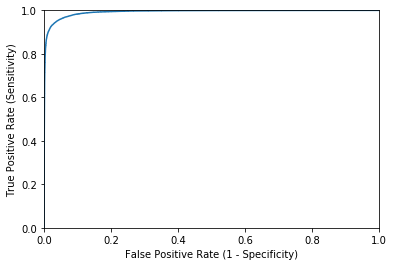

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


GB = GradientBoostingClassifier()
GB.fit(X_train, y_train)

fpr, tpr, thresholds = metrics.roc_curve(y, GB.predict_proba(X)[:, 1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')


In [63]:
cross_val_score(GB, X, y, cv=3, scoring='roc_auc').mean()

0.9906995979297947

In [40]:
# save the models for quick loading in the future
from sklearn.externals import joblib
joblib.dump(logreg, 'logreg.pkl') 

# load the model
from sklearn.externals import joblib
logreg = joblib.load('logreg.pkl') 

# save the models for quick loading in the future
from sklearn.externals import joblib
joblib.dump(GB, 'GB.pkl') 

# load the model
from sklearn.externals import joblib
GB = joblib.load('GB.pkl') 